In [36]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지


In [37]:
df = pd.read_csv('data2.csv')
df1 = df[df['label']=='temp']

In [38]:
df1

,label,T [degC],P [bar],W_cat [g],Time [h],N_Gly [mmol],N_KOH [mmol],N_H2 [mmol],N_LA [mmol],N_PDO [mmol],N_FA [mmol],N_GA [mmol],N_ME [mmol],N_EG [mmol]
6,temp,200,15.518495,0.3,0.0,250.00,375.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,temp,170,39.227423,0.3,2.0,139.75,275.725604,88.298793,92.250001,13.609762,3.762201,3.262195,0.878040,0.878040
8,temp,180,56.811922,0.3,2.0,88.25,229.636367,128.977265,135.999999,19.663635,4.931810,4.431824,1.404550,1.404550
9,temp,190,73.437851,0.3,2.0,47.25,191.540244,164.169513,168.499990,24.408048,8.229886,6.729881,2.362078,2.362078
10,temp,200,92.654542,0.3,2.0,14.00,155.283828,203.432345,201.249991,22.830920,9.608083,8.858098,2.685998,2.685998


In [39]:
# parameters initialization
Wi = 66.625
VL = 41.253968 # mL# h2 solubility parameter
p00 = 0.2638
p01 = 5.443e-4
p02 = -2.45e-7
p10 = -1.545e-3
p20 = 2.205e-6
p11 = 9.105e-7
mw_h2o = 18 # g/mol, water molweight
mw_h2 = 2 # g/mol, hydrogen molweight

In [40]:
# Concentration initialization
N0 = np.array([
    df1.iloc[0]['N_Gly [mmol]'],    # 글리세롤
    df1.iloc[0]['N_KOH [mmol]'],    # KOH
    df1.iloc[0]['N_H2 [mmol]'],     # 수소
    df1.iloc[0]['N_LA [mmol]'],     # 젖산
    df1.iloc[0]['N_PDO [mmol]'],    # 1,3-PDO
    df1.iloc[0]['N_FA [mmol]'],     # 포름산
    df1.iloc[0]['N_GA [mmol]'],     # 글리콜산
    df1.iloc[0]['N_ME [mmol]'],     # 메탄올
    df1.iloc[0]['N_EG [mmol]']      # 에틸렌글리콜
], dtype=np.float32)

# 각 온도별 실험 데이터 준비
temp_data = []
for i in range(1, len(df1)):
    temp_data.append({
        'T': df1.iloc[i]['T [degC]'],
        'time': df1.iloc[i]['Time [h]'],
        'N_exp': np.array([
            df1.iloc[i]['N_Gly [mmol]'],
            df1.iloc[i]['N_KOH [mmol]'],
            df1.iloc[i]['N_H2 [mmol]'],
            df1.iloc[i]['N_LA [mmol]'],
            df1.iloc[i]['N_PDO [mmol]'],
            df1.iloc[i]['N_FA [mmol]'],
            df1.iloc[i]['N_GA [mmol]'],
            df1.iloc[i]['N_ME [mmol]'],
            df1.iloc[i]['N_EG [mmol]']
        ])
    })

In [41]:
temp_data

[{'T': np.int64(170),
  'time': np.float64(2.0),
  'N_exp': array([139.75      , 275.7256037 ,  88.29879264,  92.25000068,
          13.60976173,   3.76220072,   3.26219492,   0.87803977,
           0.87803977])},
 {'T': np.int64(180),
  'time': np.float64(2.0),
  'N_exp': array([ 88.25      , 229.6363674 , 128.9772653 , 135.9999985 ,
          19.66363477,   4.9318098 ,   4.43182437,   1.40454967,
           1.40454967])},
 {'T': np.int64(190),
  'time': np.float64(2.0),
  'N_exp': array([ 47.25      , 191.5402436 , 164.1695127 , 168.4999899 ,
          24.40804839,   8.22988588,   6.72988056,   2.36207847,
           2.36207847])},
 {'T': np.int64(200),
  'time': np.float64(2.0),
  'N_exp': array([ 14.        , 155.2838276 , 203.4323448 , 201.2499912 ,
          22.83092013,   9.6080828 ,   8.8580984 ,   2.68599806,
           2.68599806])}]

In [42]:
def ode_system(t, N, Ea_params,T):

    wcat = 0.3*0.02 # Pt 함량 0.3 g의 2%
    wpet = 0.3

    VL = 41.253968 # mL
    VG = 145 - VL
    C = N/VL # mmol/mL = M
    
    T = T
    P_H2O = 10**(8.14019-1810.94/(244.485+T))/750.062 # Antoine equation
    vg = 8.314*(T+273.15)/(P_H2O*1e5)
    NG_H2O = 1/(vg*1e3)*VG

    P_H2 = (N[2]/1e3)/(VG/1e6)*8.314*(T+273.15)/1e5
    S_H2 = p00 + (T)*p10 + P_H2*p01 + (T)**2*p20 + P_H2**2*p02 + (T)*P_H2*p11
    WL = Wi - (N[2])*mw_h2/1000 - NG_H2O*mw_h2o/1000
    NL_H2 = S_H2*WL
    NLf_H2 = min(N[2], NL_H2)

    C[2] = NLf_H2/VL
        # C의 0인 성분을 1e-8로 수정
    C[C < 0] = 1e-8
    # kg1 0 # KGly 1 # KH2 2 # KPDO 3 # kd1 4 # kd2 5 # kd3 6 # kp1 7 # kp2 8

    # 글리세롤 0 # KOH 1 # 수소 2 # 젖산 3 # 1,3-PDO 4 # 포름산 5 # 글리콜산 6 # 메탄올 7 # 에틸렌글리콜 8
    # parameter
    k00 = 10**(10.00617065)
    k10 = 10**(-5.27330119)
    k20 = 10**(0.6561819)
    k30 = 10**(-7.98722129)
    k40 = 10**(1.66786216)
    k50 = 10**(-1.391634)
    k60 = 10**(1.53912482)
    k70 = 10**(-0.16267448)
    k80 = 10**(2.2901179)

    k0 = k00*np.exp(-Ea_params[0]/8.314*(1/(T+273.15)-1/(200+273.15))) # kg1
    k1 = k10*np.exp(Ea_params[1]/8.314*(1/(T+273.15)-1/(200+273.15))) # KGly
    k2 = k20*np.exp(Ea_params[2]/8.314*(1/(T+273.15)-1/(200+273.15))) # KH2
    k3 = k30*np.exp(Ea_params[3]/8.314*(1/(T+273.15)-1/(200+273.15))) # KPDO
    k4 = k40*np.exp(-Ea_params[4]/8.314*(1/(T+273.15)-1/(200+273.15))) # kd1
    k5 = k50*np.exp(-Ea_params[5]/8.314*(1/(T+273.15)-1/(200+273.15))) # kd2
    k6 = k60*np.exp(-Ea_params[6]/8.314*(1/(T+273.15)-1/(200+273.15))) # kd3
    k7 = k70*np.exp(-Ea_params[7]/8.314*(1/(T+273.15)-1/(200+273.15))) # kp1
    k8 = k80*np.exp(Ea_params[8]/8.314*(1/(T+273.15)-1/(200+273.15))) # kp2
    
    # Intensive Reaction Rate
    theta = 1 + k1*C[0] + (k2*C[2])**0.5 + k3*C[4]
    rg1= k0*k1*C[0]/(theta**3) # Glycerol -> DHA + H2
    rd1 = k4 # DHA -> PRA + H2O
    rd2 = k5*(C[1]**2) # DHA + 2KOH -> FA + GA + 2H2
    rd3 = k6*(C[2]**2) # DHA + 2H2 -> ME + EG
    rp1 = k7*C[1] # PRA + KOH -> LA
    rp2 = k8*k2**2*C[2]**2/(theta**5) # PRA + 2H2 -> PDO

    # Extensive Reaction RAte
    rg1_ext = rg1*wcat
    rd1_ext = rd1*VL/1000
    rd2_ext = rd2*VL/1000
    rd3_ext = rd3*VL/1000
    rp1_ext = rp1*VL/1000
    rp2_ext = rp2*wcat

    fd1 = rd1_ext/(rd1_ext+rd2_ext+rd3_ext)
    fd2 = rd2_ext/(rd1_ext+rd2_ext+rd3_ext)
    fd3 = rd3_ext/(rd1_ext+rd2_ext+rd3_ext)

    fp1 = rp1_ext/(rp1_ext+rp2_ext)
    fp2 = rp2_ext/(rp1_ext+rp2_ext)

    dN0dt = -rg1_ext
    dN1dt = -2*rg1_ext*fd2 - rg1_ext*fd1*fp1
    dN2dt = rg1_ext + 2*rg1_ext*fd2 - 2*rg1_ext*fd3 - 2*rg1_ext*fd1*fp2
    dN3dt = rg1_ext*fd1*fp1
    dN4dt = rg1_ext*fd1*fp2
    dN5dt = rg1_ext*fd2
    dN6dt = rg1_ext*fd2
    dN7dt = rg1_ext*fd3
    dN8dt = rg1_ext*fd3

    return np.array([dN0dt, dN1dt, dN2dt, dN3dt, dN4dt, dN5dt, dN6dt, dN7dt, dN8dt])


In [43]:
t_eval = np.array(df1.iloc[0:]['Time [h]'].values, dtype=np.float32)

In [44]:
# 각 온도별로 ODE 풀기
def solve_ode_for_temp(Ea_params, T, time_end):
    t_eval = np.array([0, time_end])
    sol = solve_ivp(
        ode_system,
        t_span=(0, time_end),
        y0=N0,
        t_eval=t_eval,
        args=(Ea_params, T),
        method='RK45'
    )
    return sol.y[:, -1]  # 마지막 시점의 결과만 반환

In [45]:
# 수정된 목적 함수 - 모든 온도 조건을 동시에 고려
def objective_function(Ea_params):
    total_error = 0
    
    for data in temp_data:
        try:
            # 각 온도별로 ODE 계산
            N_pred = solve_ode_for_temp(Ea_params, data['T'], data['time'])
            
            # 각 성분별 상대 오차 계산
            error = 0
            for i in range(9):
                # T=190°C에서 PDO (i=4) 제외
                if data['T'] == 190 and i == 4:
                    continue
                    
                if data['N_exp'][i] != 0:
                    relative_error = ((N_pred[i] - data['N_exp'][i]) / data['N_exp'][i])**2
                else:
                    relative_error = N_pred[i]**2
                error += relative_error
            
            total_error += error
            
        except Exception as e:
            print(f"Error at T={data['T']}°C: {e}")
            return 1e10
    
    return total_error

In [46]:

best_loss = float('inf')
best_x = np.ones(9)
x0 = np.ones(9)*1000
for i in range(100):  # 100번 반복
    result = minimize(
        objective_function,
        x0=x0,
        method='L-BFGS-B',
        bounds = [(0, 100000) for _ in range(9)]  # Ea 값의 범위 (J/mol)
    )
    
    # 현재 시도의 loss 출력
    print(f'시도 {i+1} - Loss: {result.fun:.6f}, Best Loss: {best_loss:.6f}')
    
    if result.fun < best_loss:
        best_loss = result.fun
        best_x = result.x.copy()
        x0 = result.x.copy()  # 더 나은 결과를 얻은 경우 x0를 result.x로 갱신
    else:
        x0 = best_x.copy()  # 더 나은 결과를 얻지 못한 경우 best_x를 x0로 사용
        
    # x0에 랜덤 변화 추가
    x0 = x0 * (1 + np.random.randn(len(x0)) * 0.05)


시도 1 - Loss: 0.921014, Best Loss: inf
시도 2 - Loss: 1.074515, Best Loss: 0.921014
시도 3 - Loss: 0.893105, Best Loss: 0.921014
시도 4 - Loss: 0.882937, Best Loss: 0.893105
시도 5 - Loss: 0.932125, Best Loss: 0.882937
시도 6 - Loss: 0.911133, Best Loss: 0.882937
시도 7 - Loss: 0.888566, Best Loss: 0.882937
시도 8 - Loss: 0.855130, Best Loss: 0.882937
시도 9 - Loss: 0.995438, Best Loss: 0.855130
시도 10 - Loss: 0.765891, Best Loss: 0.855130
시도 11 - Loss: 0.658540, Best Loss: 0.765891
시도 12 - Loss: 0.781190, Best Loss: 0.658540
시도 13 - Loss: 0.612431, Best Loss: 0.658540
시도 14 - Loss: 0.578071, Best Loss: 0.612431
시도 15 - Loss: 0.699372, Best Loss: 0.578071
시도 16 - Loss: 0.589809, Best Loss: 0.578071
시도 17 - Loss: 0.566211, Best Loss: 0.578071
시도 18 - Loss: 0.521765, Best Loss: 0.566211
시도 19 - Loss: 0.549089, Best Loss: 0.521765
시도 20 - Loss: 0.473245, Best Loss: 0.521765
시도 21 - Loss: 0.488935, Best Loss: 0.473245
시도 22 - Loss: 0.523113, Best Loss: 0.473245
시도 23 - Loss: 0.516786, Best Loss: 0.473245
시도

findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
C:\Users\USER\AppData\Local\Temp\ipykernel_2676\2970214010.py:40: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_2676\2970214010.py:40: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothi

최적화 완료!
최적 Ea 값: [84637.74746254  5481.59097326 25165.18776777   991.27920153
  7192.74524449 38239.50783902 19255.07228566  1267.65902601
   492.32320831]
최종 오차: 0.222752835612049


C:\Users\USER\AppData\Local\Temp\ipykernel_2676\2970214010.py:40: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_2676\2970214010.py:40: UserWarning: Glyph 54744 (\N{HANGUL SYLLABLE HEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_2676\2970214010.py:40: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Font family 'MalgunGothic' not found.
C:\Users\USER\AppData\Local\Temp\ipykernel_2676\2970214010.py:40: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_2676\2970214010.py:40: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not f

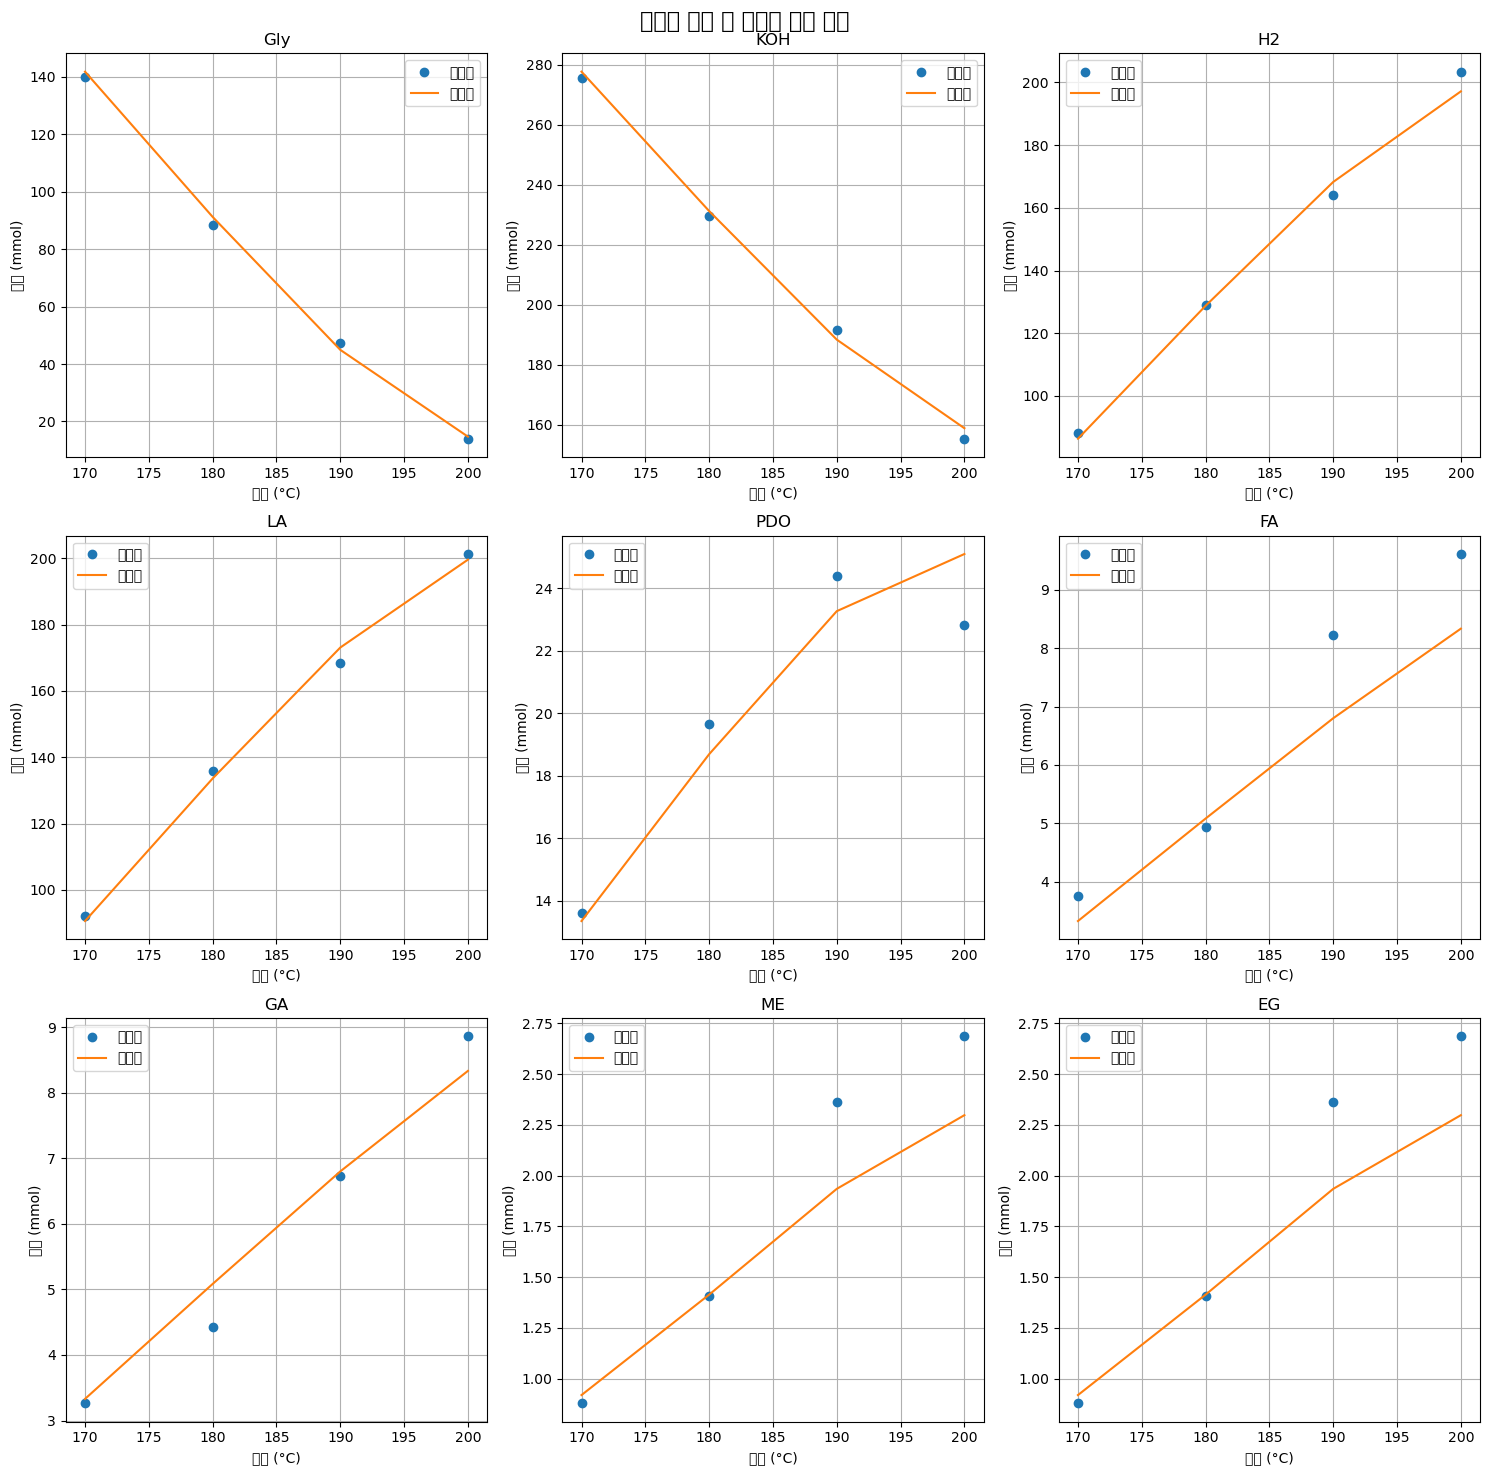

In [47]:
print("최적화 완료!")
print(f"최적 Ea 값: {best_x}")
print(f"최종 오차: {best_loss}")

# 결과 확인
optimal_Ea = best_x

# 데이터 준비
temperatures = [data['T'] for data in temp_data]
components = ['Gly', 'KOH', 'H2', 'LA', 'PDO', 'FA', 'GA', 'ME', 'EG']

# 실험값과 예측값 저장
exp_values = {comp: [] for comp in components}
pred_values = {comp: [] for comp in components}

for data in temp_data:
    N_pred = solve_ode_for_temp(optimal_Ea, data['T'], data['time'])
    for i, comp in enumerate(components):
        exp_values[comp].append(data['N_exp'][i])
        pred_values[comp].append(N_pred[i])

# 그래프 그리기
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('온도에 따른 각 성분의 농도 변화', fontsize=16)

for i, comp in enumerate(components):
    row = i // 3
    col = i % 3
    
    axs[row, col].plot(temperatures, exp_values[comp], 'o', label='실험값')
    axs[row, col].plot(temperatures, pred_values[comp], '-', label='예측값')
    axs[row, col].set_title(comp)
    axs[row, col].set_xlabel('온도 (°C)')
    axs[row, col].set_ylabel('농도 (mmol)')
    axs[row, col].legend()
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()